**Group 5:** 
- Elias Maria Bonasera (2149751)
- Alberto Casellato (2139206)
- Nicola Garbin (2156363)
- Francesco Pazzocco (2165861)

In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import truncnorm

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, SGD
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

mpl.rc('image', cmap='copper')

In [2]:
class DNN:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.xs = None # x standardized
        self.xs_train = None
        self.xs_valid = None
        self.y_train = None
        self.y_valid = None
        self.tuner = None
        self.best_models = None
        self.best_hps = None
        self.last_fit = None
    
    def standardize(self):
        x_mean = np.mean(self.x, axis=0)
        x_std = np.std(self.x, axis=0)

        self.xs = (self.x-x_mean)/x_std
    
    def split(self, percent_training=0.8):
        N_train = int( self.xs.shape[0] * percent_training )
        self.xs_train, self.y_train = self.xs[:N_train], self.y[:N_train]
        self.xs_valid, self.y_valid = self.xs[N_train:], self.y[N_train:]
    
    def random_search(self, build_model, epochs=3, objective="val_accuracy", 
                      max_trials=3, executions_per_trial=2,
                      directory="results", project_name="project", num_models=3):
        
        self.tuner = RandomSearch(
            hypermodel=build_model,
            objective=objective,
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            overwrite=True,
            directory=directory,
            project_name=project_name,
        )
        
        self.tuner.search(
            self.xs_train, self.y_train, 
            epochs=epochs, 
            validation_data=(self.xs_valid, self.y_valid)
        )
        
        self.best_models = self.tuner.get_best_models(num_models=num_models)
        self.best_hps = self.tuner.get_best_hyperparameters(num_models)
        self.tuner.results_summary(1)
    
    def fit(self, ix_model=0, epochs=100, batch_size=50, verbose=1):

        self.last_fit = self.best_models[ix_model].fit(
            self.xs_train, self.y_train,
            epochs = epochs, 
            batch_size = batch_size,
            validation_data = (self.xs_valid, self.y_valid),
            verbose = verbose
        )
        
    def show_train_vs_valid(self):
        fig, axes = plt.subplots(1, 2, figsize=(12,5))

        # accuracy
        axes[0].plot(self.last_fit.history["accuracy"], label="train")
        axes[0].plot(self.last_fit.history["val_accuracy"], label="valid.")
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("accuracy")
        axes[0].legend()

        # loss
        axes[1].plot(self.last_fit.history["loss"], label="train")
        axes[1].plot(self.last_fit.history["val_loss"], label="valid.")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("loss")
        axes[1].legend()

        plt.show()
    

In [3]:
def build_model(hp):
    L = 8
    
    # model
    model = Sequential()
    model.add( 
        Dense(
            L, input_shape=(L,), 
            activation=hp.Choice(f"activation_0", ["sigmoid", "tanh", "relu", "elu", "leaky_relu"])
        )
    )
    
    for i in range(3):
        model.add(
            Dense(
                units=20, 
                activation=hp.Choice(f"activation_{i+1}", ["sigmoid", "tanh", "relu", "elu", "leaky_relu"])
            )
        )
        
        model.add( Dropout(rate=hp.Choice(f"rate_{i+1}", [0., 0.1, 0.2])) )
        
    model.add( Dense(units=1, activation="sigmoid") )
    
    # compile
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    optimizers = {"Adam": Adam, "RMSprop": RMSprop, "Nesterov": Nadam, "SGD": SGD}
    opt_name = hp.Choice("optimizer", list(optimizers.keys()))
    model.compile(
        optimizer=optimizers[opt_name](learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

x = np.loadtxt("./DATA/data-for-DNN_type3_L8.dat", delimiter=" ")
y = np.loadtxt("./DATA/labels-for-DNN_type3_L8.dat", delimiter=" ")
y = y.astype("int")

In [4]:
network = DNN(x, y)
network.standardize()
network.split()
network.random_search(build_model, epochs=10,
                      max_trials=10, executions_per_trial=2, num_models=10)

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.574999988079071

Best val_accuracy So Far: 0.6912499964237213
Total elapsed time: 00h 01m 02s


/home/alberto/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/alberto/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/alberto/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in results/project
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
activation_0: tanh
activation_1: relu
rate_1: 0.0
activation_2: relu
rate_2: 0.0
activation_3: leaky_relu
rate_3: 0.1
lr: 0.037001119377633965
optimizer: Adam
Score: 0.6912499964237213


In [5]:
network.fit(epochs=100, verbose=0)

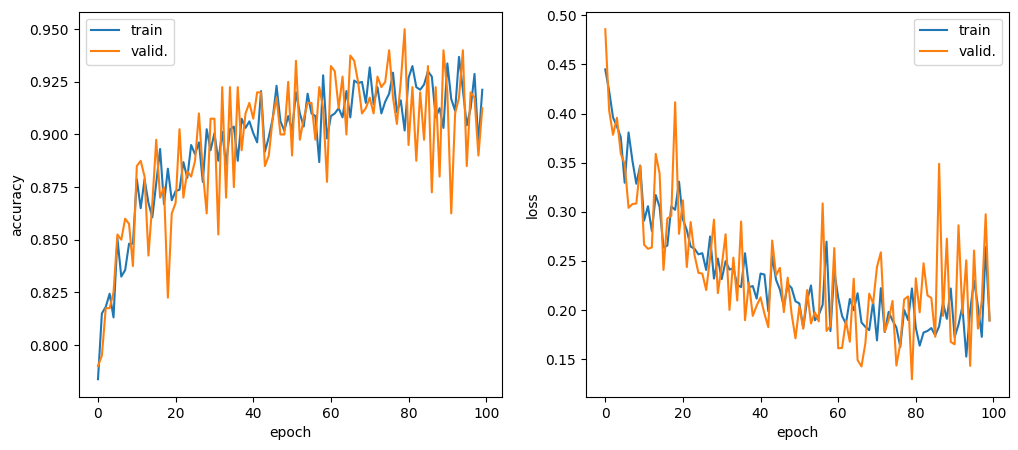

In [6]:
network.show_train_vs_valid()

We can see that there is no sign of overfitting since the validation accuracy follows the trend of the training accuracy, and also the validation loss doesn't increase with the number of epochs.

In [7]:
list_acc = []

for i in range(len(network.best_models)):
    network.fit(ix_model=i, verbose=0)
    acc = network.last_fit.history['accuracy'][-1]
    list_acc.append(acc)
    
list_ix = []
best_acc = max(list_acc)
for i, acc in enumerate(list_acc):
    if abs(acc - best_acc) < 0.1:
        list_ix.append(i)

In [8]:
def cross_validate(network, ix_model, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    
    list_acc = []
    for train_index, test_index in kf.split(network.xs):
        x_train, x_test = network.xs[train_index], network.xs[test_index]
        y_train, y_test = network.y[train_index], network.y[test_index]
        network.best_models[ix_model].fit(x_train, y_train, epochs=100, batch_size=50, verbose=0)
        acc = network.best_models[ix_model].evaluate(x_test, y_test, verbose=0)
        list_acc.append(acc[1])

    return np.mean(list_acc), np.std(list_acc)

list_mean_acc = []
list_std_acc = []
best_mean_acc = 0
best_ix = 0
for i in list_ix:
    mean_acc, std_acc = cross_validate(network, i)
    list_mean_acc.append(mean_acc)
    list_std_acc.append(std_acc)
    if mean_acc > best_mean_acc:
        best_mean_acc = mean_acc
        best_ix = i

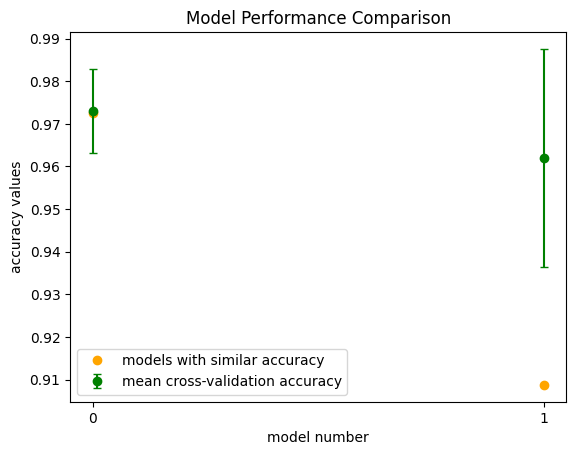

In [17]:
# plt.plot(list_acc, marker='o', color='royalblue', label='best models accuracy', linestyle='None')
plt.plot(list_ix, np.array(list_acc)[list_ix], marker='o', color='orange', label='models with similar accuracy', linestyle='None')
plt.errorbar(list_ix, list_mean_acc, yerr=list_std_acc, marker='o', capsize=3, color='green', label='mean cross-validation accuracy', linestyle='None')
plt.xticks(list(range(len(list_ix))))
plt.xlabel('model number')
plt.ylabel('accuracy values')
plt.legend()
plt.title('Model Performance Comparison')
plt.show()

Most accuracies have a high value, showing that the random search was successful in finding good sets of hyperparameters.
It is shown that there are green dots closer to orange dots, this implies that those models generalize well.

In [11]:
for i in list_ix:
    print(network.best_hps[i].values, '\n')

{'activation_0': 'tanh', 'activation_1': 'relu', 'rate_1': 0.0, 'activation_2': 'relu', 'rate_2': 0.0, 'activation_3': 'leaky_relu', 'rate_3': 0.1, 'lr': 0.037001119377633965, 'optimizer': 'Adam'} 

{'activation_0': 'leaky_relu', 'activation_1': 'relu', 'rate_1': 0.0, 'activation_2': 'relu', 'rate_2': 0.0, 'activation_3': 'leaky_relu', 'rate_3': 0.2, 'lr': 0.000729262188990327, 'optimizer': 'Adam'} 



Osservando gli iperparametri dei modelli con accuracy simile, si può osservare che come i migliori
optimizer troviamo Adam. 
SGD non si osserva in nessuno dei modelli. La maggior parte dei layer hanno come funzioni di attivazione elu, relu, e leaky_relu. 
Nel primo hidden layer abbiamo, nel maggior parte dei casi, un dropout rate di 0.1, nel secondo e nel terzo 0. Tutti i learning rate hanno valori superiori a 10^-4.

Text(0, 0.5, 'L2')

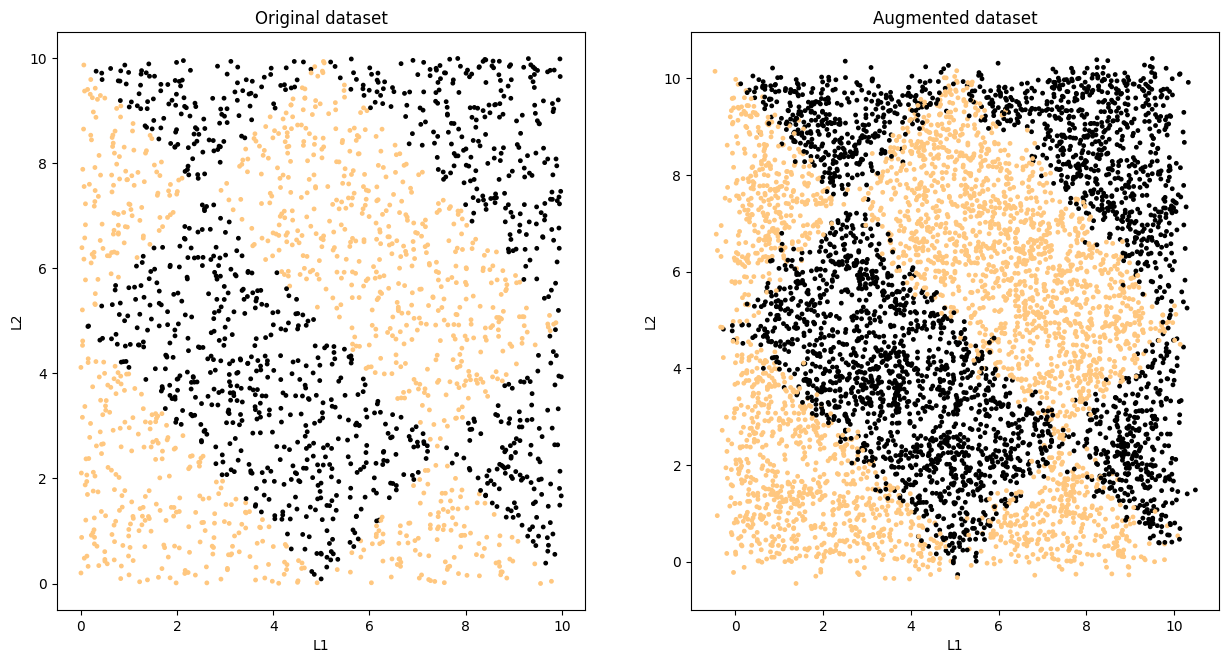

In [18]:
C           = ["L1", "L2", "L3", "L4", "L5", "L6", "L7", "L8"]
label       = "label"
df          = pd.DataFrame(x, columns = C)
df["label"] = y
#
def metric(df, i, chosen = 1):
    tmp = np.array(df[C]) - np.array(df[i:i+1][C])
    tmp = abs(tmp).mean(axis = 1)
    tmp.sort()
    return tmp[chosen] / 2
    #
#####
#
class POINTS(object):
    def __init__(self, df):
        self.df     = df
        self.new_df = None
        #
    #####
    #
    def run(self, N = 1, spread = 1):
        points = pd.DataFrame([])
        for i in range(len(self.df)):
            std  = metric(df, i, spread)
            th   = (2 * std) / std
            new_points = truncnorm.rvs(- 0.75, 0.75, loc = 0, scale = std, size = (N, 8)) + np.array(df[C].iloc[i])
            new_points = pd.DataFrame(new_points, columns = C)
            new_points[label] = df[label].iloc[i]
            points     = pd.concat([points, new_points], ignore_index = True)
            #
        #####
        #
        self.new_df = points
        #
    #####
    #
    def print(self):
        return pd.concat([self.df, self.new_df], ignore_index = True)
        #
    #####
    #
#####

m = POINTS(df)
m.run(N = 2, spread = 2)
new_df = m.print()

x_new, y_new = np.array(new_df[C]), np.array(new_df["label"])

fig,  axs = plt.subplots(1, 2, figsize = (15, 7.5))
axs[0].scatter(x[:, 0],     x[:, 1],     s = 6, c = y)
axs[1].scatter(x_new[:, 0], x_new[:, 1], s = 6, c = y_new)
axs[0].set_title("Original dataset")
axs[1].set_title("Augmented dataset")
axs[0].set_xlabel("L1")
axs[1].set_xlabel("L1")
axs[0].set_ylabel("L2")
axs[1].set_ylabel("L2")

In [13]:
for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    N_r = int(p * len(x))
    x_r = x[:N_r]
    y_r = y[:N_r]
    network.x = x_r
    network.y = y_r
    network.standardize()
    network.split()
    network.fit(ix_model=best_ix, verbose=0)
    print(p, network.last_fit.history['accuracy'][-1])
    #network.show_train_vs_valid()
#we can see that the accuracy of the model tends to decrease as the size of the whole dataset increases

0.1 1.0
0.2 0.996874988079071
0.3 0.9750000238418579
0.4 0.9984375238418579
0.5 0.9975000023841858
0.6 0.9979166388511658
0.7 0.9892857074737549
0.8 0.9820312261581421
0.9 0.988194465637207
0.95 0.9888157844543457


In [14]:
for i in [1, 2, 3, 4, 5, 10, 20, 30]:
    m.run(N = i, spread = 2)
    new_df = m.print()
    #
    x_a = new_df[C].to_numpy()
    y_a = new_df[label].to_numpy()
    network.x = x_a.astype(float)
    network.y = y_a.astype(int)
    #
    network.standardize()
    network.xs_valid, network.y_valid = network.xs[:400], network.y[:400]
    network.xs_train, network.y_train = network.xs[400:], network.y[400:]
    network.fit(ix_model=best_ix, verbose=0)
    print(i, network.last_fit.history['accuracy'][-1])

1 0.9438889026641846
2 0.9385714530944824
3 0.9353947639465332
4 0.932604193687439
5 0.9307758808135986
10 0.9171759486198425
20 0.9258654117584229
30 0.9210389852523804


In [15]:
#we can see that the accuracy of the model tends to decrease as the size of the training set increases